<a href="https://colab.research.google.com/github/jakubweglowski/Machine-Learning-Summer-2024-25/blob/main/Homework09_multi-layer-perceptron-MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Necessary Imports
import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import copy # To duplicate model for Task 2 modification if needed

In [ ]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Define a Simple MLP Model for MNIST ---
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = torch.nn.Sequential(   #Sequential is a structure which allows stacking layers one on another in such a way,
                                          #that output from a preceding layer serves as input to the next layer
            torch.nn.Flatten(),   #change the last three orders in data (with dimensions 1, 28 and 28 respectively) into one order of dimensions (1*28*28)
            torch.nn.Linear(1*28*28, 1024),  #which is used as INPUT to the first Linear layer
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 2048),   #IMPORTANT! Please observe, that the OUTPUT dimension of a preceding layer is always equal to the INPUT dimension of the next layer.
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 256),
            torch.nn.ReLU(),            #ReLU (or a Sigmoid if you want) is a nonlinear function which is used in-between layers
            torch.nn.Linear(256, 10),
        )
        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):
        x = self.mlp(x)
        x = self.dropout(x)
        return x

Using device: cuda


In [ ]:
# --- 2. Train the Model (or Load Pre-trained) ---
# Basic training function (run once if no pre-trained model is available)
def train_model(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# Basic test function
def test_model(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.functional.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    return accuracy

In [ ]:
# MNIST Data Loading and Preprocessing
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,)) # MNIST mean and std dev
])

# Check if model file exists
model_path = 'mnist_cnn.pth'
model = MLP().to(device)
train_needed = True

try:
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Loaded pre-trained model from {model_path}")
    # Optionally run test to confirm performance
    test_dataset = torchvision.datasets.MNIST('../data', train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)
    test_model(model, device, test_loader)
    train_needed = False
except FileNotFoundError:
    print(f"Model file {model_path} not found. Training a new model.")
    train_needed = True
except Exception as e:
     print(f"Could not load model due to error: {e}. Training a new model.")
     train_needed = True

if train_needed:
    print("Training the model...")
    train_dataset = torchvision.datasets.MNIST('../data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.MNIST('../data', train=False, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 5 # Train for a few epochs

    for epoch in range(1, num_epochs + 1):
        train_model(model, device, train_loader, optimizer, epoch)
        test_model(model, device, test_loader)

    # Save the trained model
    torch.save(model.state_dict(), model_path)
    print(f"Model trained and saved to {model_path}")

Model file mnist_cnn.pth not found. Training a new model.
Training the model...
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.294129
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.445237
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.155765
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.171627
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.232482
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.191524
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.271136
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.233502
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.202884
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.147975

Test set: Average loss: 0.1421, Accuracy: 9611/10000 (96.11%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.149291
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.079035
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.102052
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.106522
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.189873
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.136711
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.071497
Train Epoch: 2 [44

In [ ]:
# --- 3. Prepare Model for Input Optimization ---
# Freeze model weights
model.eval() # Set model to evaluation mode (disables dropout, etc.)
for param in model.parameters():
    param.requires_grad = False

# --- Helper function to visualize results ---
def plot_images(images, targets, title="Generated Images"):
    images = images.detach().cpu().numpy()
    # De-normalize if necessary - for this task, we optimize directly,
    # so de-normalization based on MNIST stats isn't strictly needed,
    # but clamping might be useful. Let's plot directly first.
    # Clamp values to a displayable range if they went wild during optimization
    images = np.clip(images, images.mean() - 3*images.std(), images.mean() + 3*images.std())

    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    axes = axes.ravel()
    for i in range(10):
        img = images[i].squeeze() # Remove channel dim (1, 28, 28) -> (28, 28)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Target: {targets[i]}")
        axes[i].axis('off')
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()


--- Starting Task 1: Generating single digits ---
Task 1 Step [100/500], Loss: 0.0000, Accuracy: 1.00
Task 1 Step [200/500], Loss: 0.0000, Accuracy: 1.00
Task 1 Step [300/500], Loss: 0.0000, Accuracy: 1.00
Task 1 Step [400/500], Loss: 0.0000, Accuracy: 1.00
Task 1 Step [500/500], Loss: 0.0000, Accuracy: 1.00

Task 1 Final Results:
Image 0: Target=0, Predicted=0, Confidence=1.0000
Image 1: Target=1, Predicted=1, Confidence=1.0000
Image 2: Target=2, Predicted=2, Confidence=1.0000
Image 3: Target=3, Predicted=3, Confidence=1.0000
Image 4: Target=4, Predicted=4, Confidence=1.0000
Image 5: Target=5, Predicted=5, Confidence=1.0000
Image 6: Target=6, Predicted=6, Confidence=1.0000
Image 7: Target=7, Predicted=7, Confidence=1.0000
Image 8: Target=8, Predicted=8, Confidence=1.0000
Image 9: Target=9, Predicted=9, Confidence=1.0000


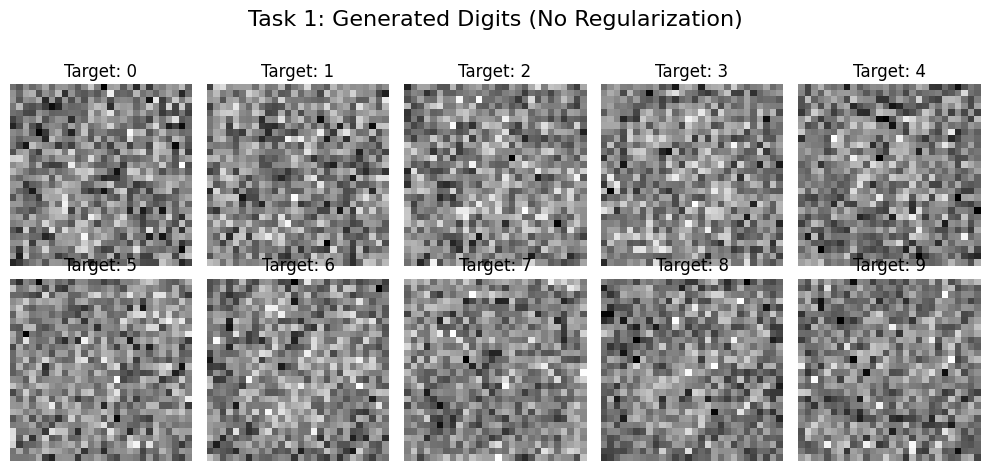

In [ ]:
# --- Task 1: Generate Images for Digits 0-9 from Noise ---

print("\n--- Starting Task 1: Generating single digits ---")

# Optimization parameters
learning_rate_task1 = 0.05 # Can be tuned
num_steps_task1 = 500    # Number of optimization iterations

# 1. Initialize input batch with Gaussian noise
dreamed_input_batch_task1 = torch.randn(10, 1, 28, 28, device=device, requires_grad=True)

# 2. Define target labels
target_labels_task1 = torch.arange(10, device=device) # Digits 0 through 9

# 3. Define optimizer - **optimizing the input batch**
optimizer_task1 = torch.optim.Adam([dreamed_input_batch_task1], lr=learning_rate_task1)

# 4. Optimization loop
loss_fn = torch.nn.CrossEntropyLoss()

for step in range(num_steps_task1):
    optimizer_task1.zero_grad()

    # Forward pass: Get model's prediction for the current input batch
    outputs = model(dreamed_input_batch_task1)

    # Calculate loss: How far are predictions from target labels?
    loss = loss_fn(outputs, target_labels_task1)

    # Backward pass: Calculate gradients of the loss w.r.t. the input batch pixels
    loss.backward()

    # Update step: Modify the input batch pixels using the gradients
    optimizer_task1.step()

    # Optional: Clamp the input values to stay within a reasonable range, e.g., typical MNIST range
    # This can sometimes help prevent extreme pixel values and yield better visuals
    # mean, std = 0.1307, 0.3081
    # dreamed_input_batch_task1.data.clamp_(mean - 3*std, mean + 3*std) # Clamp roughly within 3 std devs

    if (step + 1) % 100 == 0:
        # Calculate current accuracy for feedback
        with torch.no_grad():
             pred = model(dreamed_input_batch_task1).argmax(dim=1)
             accuracy = (pred == target_labels_task1).float().mean()
        print(f'Task 1 Step [{step+1}/{num_steps_task1}], Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.2f}')

# Get final predictions and confidence
with torch.no_grad():
    final_outputs_task1 = model(dreamed_input_batch_task1)
    final_probs_task1 = torch.nn.functional.softmax(final_outputs_task1, dim=1)
    final_preds_task1 = final_probs_task1.argmax(dim=1)
    confidences_task1 = final_probs_task1.max(dim=1)[0]

print("\nTask 1 Final Results:")
for i in range(10):
    print(f"Image {i}: Target={target_labels_task1[i].item()}, Predicted={final_preds_task1[i].item()}, Confidence={confidences_task1[i].item():.4f}")

# Visualize the results for Task 1
plot_images(dreamed_input_batch_task1, target_labels_task1.cpu().numpy(), title="Task 1: Generated Digits (No Regularization)")

## **Discussion Task 1**

**Do the generated images resemble real MNIST digits? Why or why not?**

* **Resemblance:** The generated images do not show resemblance to the target digits. They usually look quite noisy or abstract compared to typical handwritten digits from the MNIST dataset. We might try to find the general shape or key features (like a loop for $0$' or $8$, a vertical bar for $1$), but they are frequently embedded in or overlaid with high-frequency noise patterns.
* **Explanation:**
    * **Optimization Goal:** The optimization process is solely focused on maximizing the activation of the target neuron (or minimizing the cross-entropy loss for that target class). It finds the "path of least resistance" through the input space to achieve this goal.
    * **Network's Perspective:** The network has learned specific features during training that correlate with each digit. The optimizer exploits *exactly* these learned features. If the network learned that certain high-frequency noise patterns strongly correlate (even spuriously) with a digit class during training, the optimizer will happily generate those patterns because they efficiently satisfy the objective. It doesn't care about human aesthetics or what a "typical" digit looks like.
    * **Lack of Constraints:** Without regularization (like the $L_2$ penalty in Task 3), there's no penalty for generating inputs with high variance or unrealistic pixel values. The optimizer is free to create any pattern, however "unnatural," as long as it returns the desired classification.

## **Task 2: Generating an Image Similar to Two Digits**

**Discuss how you would approach generating an image that bares similarity to two or more digits simultaneously. Implement your idea.**

To generate an image that the network perceives as similar to two (or more) digits simultaneously, we need to modify the optimization objective. Instead of pushing the network towards classifying the image as *one* specific digit, we want it to classify it strongly as *both* (or multiple) target digits. Here are a few ways to approach this:

1.  **Loss Blending (Chosen Approach):** Calculate the loss for *each* target digit separately using the same input image, and then minimize the *sum* (or average) of these losses. For example, to generate an image resembling both $3$ and $5$, calculate `loss_3 = CrossEntropyLoss(output, target_3)` and `loss_5 = CrossEntropyLoss(output, target_5)`. The total loss to minimize would be `total_loss = loss_3 + loss_5`. This encourages the optimizer to find an input that activates *both* the neuron for '3' and the neuron for '5'.
2.  **Target Probability Blending:** Define a target probability distribution that assigns high probability to the desired digits (e.g., 0.5 for '3', 0.5 for '5', and 0 for others). Then, use a loss function that compares the network's output distribution (after softmax) to this target distribution, such as Kullback-Leibler (KL) Divergence loss. This requires the network's output to be converted to probabilities (using Softmax) and the loss function `nn.KLDivLoss` expects log-probabilities as input.
3.  **Feature Space Interpolation (More Advanced):** This involves generating images for individual digits first (like in Task 1) and then trying to interpolate between their representations in one of the network's hidden layers. This is more complex to implement.

We will try to implement **Approach 1 (Loss Blending)** as it's straightforward and effective. We will "blend" images resembling $3$ and $5$.

Step [100/700], Total Loss: 1.3863, Prob(3): 0.497, Prob(5): 0.503
Step [200/700], Total Loss: 1.3863, Prob(3): 0.500, Prob(5): 0.500
Step [300/700], Total Loss: 1.3863, Prob(3): 0.500, Prob(5): 0.500
Step [400/700], Total Loss: 1.3863, Prob(3): 0.500, Prob(5): 0.500
Step [500/700], Total Loss: 1.3863, Prob(3): 0.500, Prob(5): 0.500
Step [600/700], Total Loss: 1.3863, Prob(3): 0.500, Prob(5): 0.500
Step [700/700], Total Loss: 1.3863, Prob(3): 0.500, Prob(5): 0.500

Final Probabilities for blended image (Targets: 3 & 5):
Digit 0: 0.0000
Digit 1: 0.0000
Digit 2: 0.0000
Digit 3: 0.5000
Digit 4: 0.0000
Digit 5: 0.5000
Digit 6: 0.0000
Digit 7: 0.0000
Digit 8: 0.0000
Digit 9: 0.0000


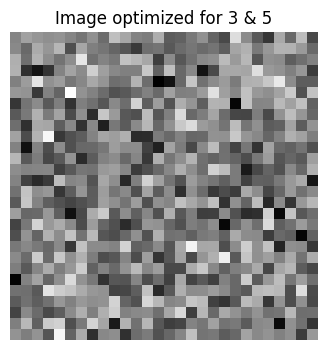

In [ ]:
# Target digits for the blended image
digit1 = 3
digit2 = 5

# Optimization parameters
learning_rate_task2 = 0.05
num_steps_task2 = 700 # Might need more steps for combined objective

# Initialize a single input image with noise
# Use clone().detach() if starting from previous results, otherwise start fresh:
# dreamed_input_task2 = dreamed_input_batch_task1[digit1].clone().detach().unsqueeze(0).requires_grad_(True) # Start from digit 1's result
dreamed_input_task2 = torch.randn(1, 1, 28, 28, device=device, requires_grad=True) # Start fresh from noise

# Define target labels
target1 = torch.tensor([digit1], device=device)
target2 = torch.tensor([digit2], device=device)

# Define optimizer for the single input image
optimizer_task2 = torch.optim.Adam([dreamed_input_task2], lr=learning_rate_task2)

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimization loop for Task 2
for step in range(num_steps_task2):
    optimizer_task2.zero_grad()

    # Forward pass
    output = model(dreamed_input_task2)

    # Calculate combined loss
    loss1 = loss_fn(output, target1)
    loss2 = loss_fn(output, target2)
    loss = loss1 + loss2 # Minimize the sum of losses

    # Backward pass
    loss.backward()

    # Update step
    optimizer_task2.step()

    # Optional clamping
    # dreamed_input_task2.data.clamp_(mean - 3*std, mean + 3*std)

    if (step + 1) % 100 == 0:
         with torch.no_grad():
             probs = torch.nn.functional.softmax(model(dreamed_input_task2), dim=1).squeeze()
         print(f'Step [{step+1}/{num_steps_task2}], Total Loss: {loss.item():.4f}, Prob({digit1}): {probs[digit1]:.3f}, Prob({digit2}): {probs[digit2]:.3f}')


# Get final predictions and probabilities for the blended image
with torch.no_grad():
    final_output_task2 = model(dreamed_input_task2)
    final_probs_task2 = torch.nn.functional.softmax(final_output_task2, dim=1).squeeze() # Remove batch dim

print(f"\nFinal Probabilities for blended image (Targets: {digit1} & {digit2}):")
for i in range(10):
    print(f"Digit {i}: {final_probs_task2[i].item():.4f}")

# Visualize the result for Task 2
img_task2 = dreamed_input_task2.detach().cpu().numpy().squeeze()
plt.figure(figsize=(4, 4))
plt.imshow(img_task2, cmap='gray')
plt.title(f"Image optimized for {digit1} & {digit2}")
plt.axis('off')
plt.show()

# Task 3: Generating Digits with L2 Regularization

**Repeat the previous tasks with an additional $L_2$ penalty on noise within the images. Experiment with adding `lambda_l2 * dreamed_input_batch.pow(2).mean()` loss term, with `lambda_l2` being the penalty coefficient within an exponential progression, say from $0.001$ to $10.0$. Are the new digits recognized correctly? How does the penalty impact the digit quality? Explain.**

We will repeat Task 1 with varying $L_2$ penalty strengths.

lambda_l2 = 0.0010
(lambda=0.0010) Step [200/500], Total Loss: 0.0011, Class Loss: 0.0000, L2 Pen: 0.0011, Acc: 1.00
(lambda=0.0010) Step [400/500], Total Loss: 0.0011, Class Loss: 0.0000, L2 Pen: 0.0011, Acc: 1.00
(lambda=0.0010) Final Results:
Image 0: Target=0, Predicted=0, Confidence=1.0000 [Correct]
Image 1: Target=1, Predicted=1, Confidence=1.0000 [Correct]
Image 2: Target=2, Predicted=2, Confidence=1.0000 [Correct]
Image 3: Target=3, Predicted=3, Confidence=1.0000 [Correct]
Image 4: Target=4, Predicted=4, Confidence=1.0000 [Correct]
Image 5: Target=5, Predicted=5, Confidence=1.0000 [Correct]
Image 6: Target=6, Predicted=6, Confidence=1.0000 [Correct]
Image 7: Target=7, Predicted=7, Confidence=1.0000 [Correct]
Image 8: Target=8, Predicted=8, Confidence=1.0000 [Correct]
Image 9: Target=9, Predicted=9, Confidence=1.0000 [Correct]
Total accuracy for lambda=0.0010: 10/10


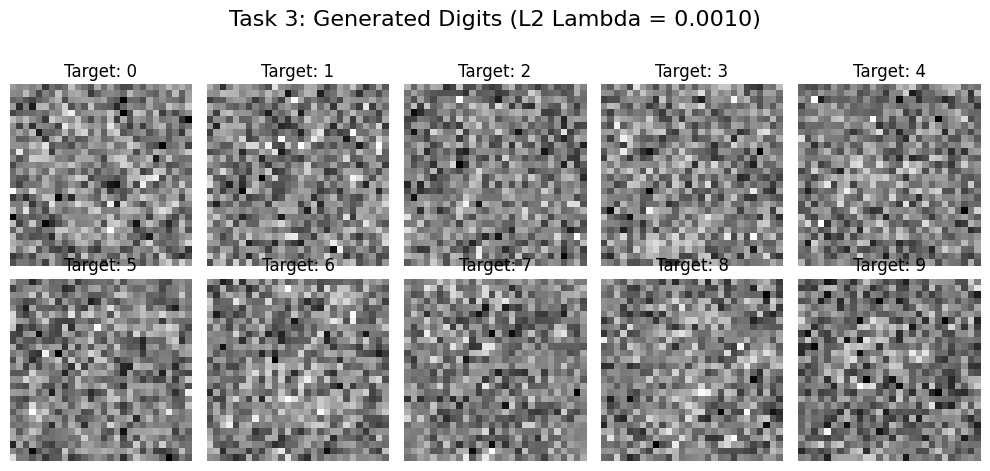

lambda_l2 = 0.0046
(lambda=0.0046) Step [200/500], Total Loss: 0.0050, Class Loss: 0.0000, L2 Pen: 0.0050, Acc: 1.00
(lambda=0.0046) Step [400/500], Total Loss: 0.0046, Class Loss: 0.0000, L2 Pen: 0.0046, Acc: 1.00
(lambda=0.0046) Final Results:
Image 0: Target=0, Predicted=0, Confidence=1.0000 [Correct]
Image 1: Target=1, Predicted=1, Confidence=1.0000 [Correct]
Image 2: Target=2, Predicted=2, Confidence=1.0000 [Correct]
Image 3: Target=3, Predicted=3, Confidence=1.0000 [Correct]
Image 4: Target=4, Predicted=4, Confidence=1.0000 [Correct]
Image 5: Target=5, Predicted=5, Confidence=1.0000 [Correct]
Image 6: Target=6, Predicted=6, Confidence=1.0000 [Correct]
Image 7: Target=7, Predicted=7, Confidence=1.0000 [Correct]
Image 8: Target=8, Predicted=8, Confidence=1.0000 [Correct]
Image 9: Target=9, Predicted=9, Confidence=1.0000 [Correct]
Total accuracy for lambda=0.0046: 10/10


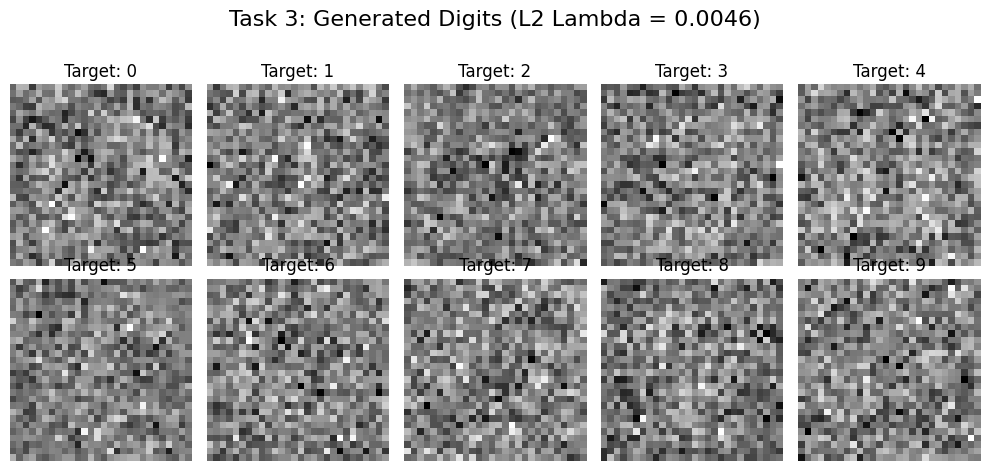

lambda_l2 = 0.0215
(lambda=0.0215) Step [200/500], Total Loss: 0.0202, Class Loss: 0.0000, L2 Pen: 0.0202, Acc: 1.00
(lambda=0.0215) Step [400/500], Total Loss: 0.0161, Class Loss: 0.0000, L2 Pen: 0.0161, Acc: 1.00
(lambda=0.0215) Final Results:
Image 0: Target=0, Predicted=0, Confidence=1.0000 [Correct]
Image 1: Target=1, Predicted=1, Confidence=1.0000 [Correct]
Image 2: Target=2, Predicted=2, Confidence=1.0000 [Correct]
Image 3: Target=3, Predicted=3, Confidence=1.0000 [Correct]
Image 4: Target=4, Predicted=4, Confidence=1.0000 [Correct]
Image 5: Target=5, Predicted=5, Confidence=1.0000 [Correct]
Image 6: Target=6, Predicted=6, Confidence=1.0000 [Correct]
Image 7: Target=7, Predicted=7, Confidence=1.0000 [Correct]
Image 8: Target=8, Predicted=8, Confidence=1.0000 [Correct]
Image 9: Target=9, Predicted=9, Confidence=1.0000 [Correct]
Total accuracy for lambda=0.0215: 10/10


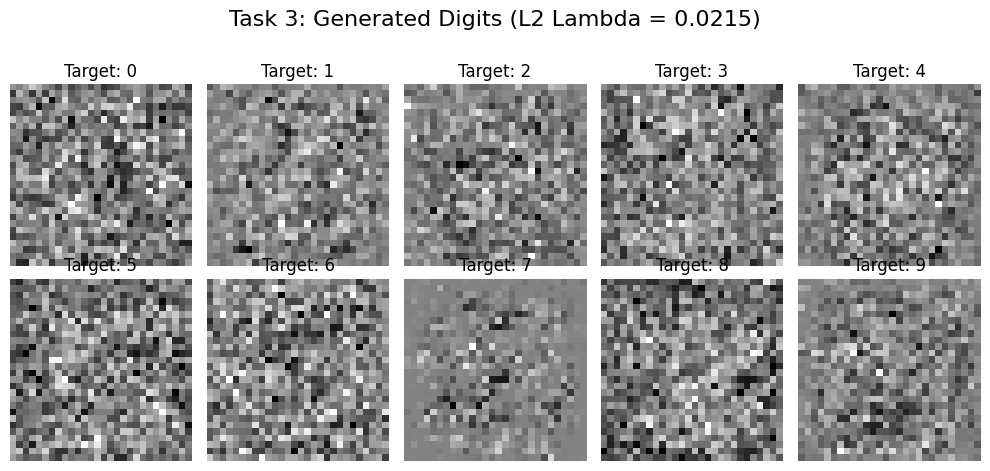

lambda_l2 = 0.1000
(lambda=0.1000) Step [200/500], Total Loss: 0.0709, Class Loss: 0.0001, L2 Pen: 0.0708, Acc: 1.00
(lambda=0.1000) Step [400/500], Total Loss: 0.0416, Class Loss: 0.0001, L2 Pen: 0.0415, Acc: 1.00
(lambda=0.1000) Final Results:
Image 0: Target=0, Predicted=0, Confidence=1.0000 [Correct]
Image 1: Target=1, Predicted=1, Confidence=0.9995 [Correct]
Image 2: Target=2, Predicted=2, Confidence=1.0000 [Correct]
Image 3: Target=3, Predicted=3, Confidence=1.0000 [Correct]
Image 4: Target=4, Predicted=4, Confidence=1.0000 [Correct]
Image 5: Target=5, Predicted=5, Confidence=1.0000 [Correct]
Image 6: Target=6, Predicted=6, Confidence=0.9998 [Correct]
Image 7: Target=7, Predicted=7, Confidence=1.0000 [Correct]
Image 8: Target=8, Predicted=8, Confidence=0.9998 [Correct]
Image 9: Target=9, Predicted=9, Confidence=0.9998 [Correct]
Total accuracy for lambda=0.1000: 10/10


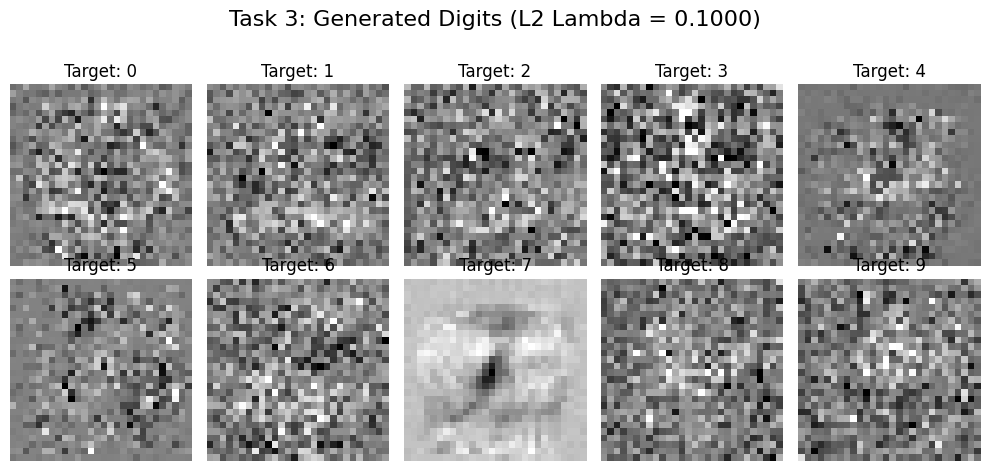

lambda_l2 = 0.4642
(lambda=0.4642) Step [200/500], Total Loss: 0.1275, Class Loss: 0.0002, L2 Pen: 0.1272, Acc: 1.00
(lambda=0.4642) Step [400/500], Total Loss: 0.0326, Class Loss: 0.0002, L2 Pen: 0.0324, Acc: 1.00
(lambda=0.4642) Final Results:
Image 0: Target=0, Predicted=0, Confidence=0.9998 [Correct]
Image 1: Target=1, Predicted=1, Confidence=0.9999 [Correct]
Image 2: Target=2, Predicted=2, Confidence=0.9999 [Correct]
Image 3: Target=3, Predicted=3, Confidence=0.9999 [Correct]
Image 4: Target=4, Predicted=4, Confidence=0.9999 [Correct]
Image 5: Target=5, Predicted=5, Confidence=0.9998 [Correct]
Image 6: Target=6, Predicted=6, Confidence=0.9998 [Correct]
Image 7: Target=7, Predicted=7, Confidence=0.9999 [Correct]
Image 8: Target=8, Predicted=8, Confidence=0.9997 [Correct]
Image 9: Target=9, Predicted=9, Confidence=0.9997 [Correct]
Total accuracy for lambda=0.4642: 10/10


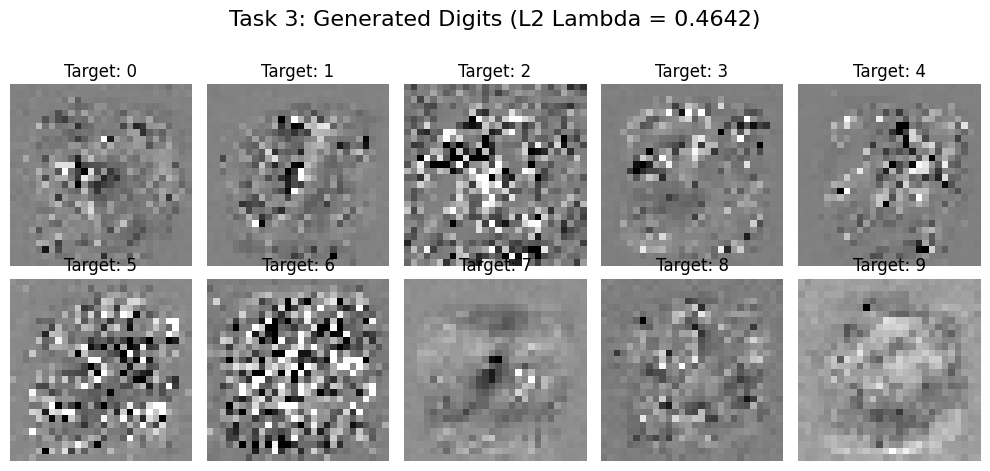

lambda_l2 = 2.1544
(lambda=2.1544) Step [200/500], Total Loss: 0.0820, Class Loss: 0.0009, L2 Pen: 0.0810, Acc: 1.00
(lambda=2.1544) Step [400/500], Total Loss: 0.0073, Class Loss: 0.0008, L2 Pen: 0.0065, Acc: 1.00
(lambda=2.1544) Final Results:
Image 0: Target=0, Predicted=0, Confidence=0.9994 [Correct]
Image 1: Target=1, Predicted=1, Confidence=0.9995 [Correct]
Image 2: Target=2, Predicted=2, Confidence=0.9995 [Correct]
Image 3: Target=3, Predicted=3, Confidence=0.9994 [Correct]
Image 4: Target=4, Predicted=4, Confidence=0.9995 [Correct]
Image 5: Target=5, Predicted=5, Confidence=0.9992 [Correct]
Image 6: Target=6, Predicted=6, Confidence=0.9992 [Correct]
Image 7: Target=7, Predicted=7, Confidence=0.9989 [Correct]
Image 8: Target=8, Predicted=8, Confidence=0.9987 [Correct]
Image 9: Target=9, Predicted=9, Confidence=0.9989 [Correct]
Total accuracy for lambda=2.1544: 10/10


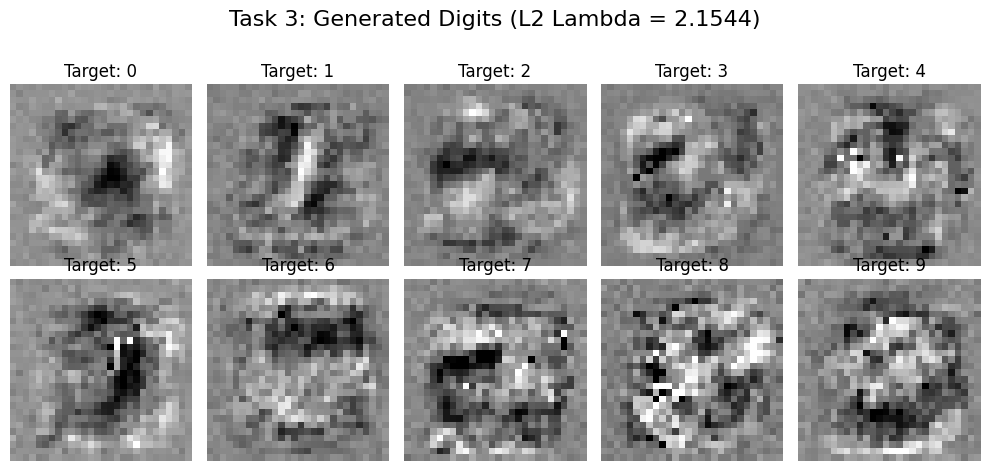

lambda_l2 = 10.0000
(lambda=10.0000) Step [200/500], Total Loss: 0.0161, Class Loss: 0.0029, L2 Pen: 0.0132, Acc: 1.00
(lambda=10.0000) Step [400/500], Total Loss: 0.0137, Class Loss: 0.0028, L2 Pen: 0.0109, Acc: 1.00
(lambda=10.0000) Final Results:
Image 0: Target=0, Predicted=0, Confidence=0.9977 [Correct]
Image 1: Target=1, Predicted=1, Confidence=0.9980 [Correct]
Image 2: Target=2, Predicted=2, Confidence=0.9980 [Correct]
Image 3: Target=3, Predicted=3, Confidence=0.9977 [Correct]
Image 4: Target=4, Predicted=4, Confidence=0.9980 [Correct]
Image 5: Target=5, Predicted=5, Confidence=0.9968 [Correct]
Image 6: Target=6, Predicted=6, Confidence=0.9969 [Correct]
Image 7: Target=7, Predicted=7, Confidence=0.9978 [Correct]
Image 8: Target=8, Predicted=8, Confidence=0.9953 [Correct]
Image 9: Target=9, Predicted=9, Confidence=0.9956 [Correct]
Total accuracy for lambda=10.0000: 10/10


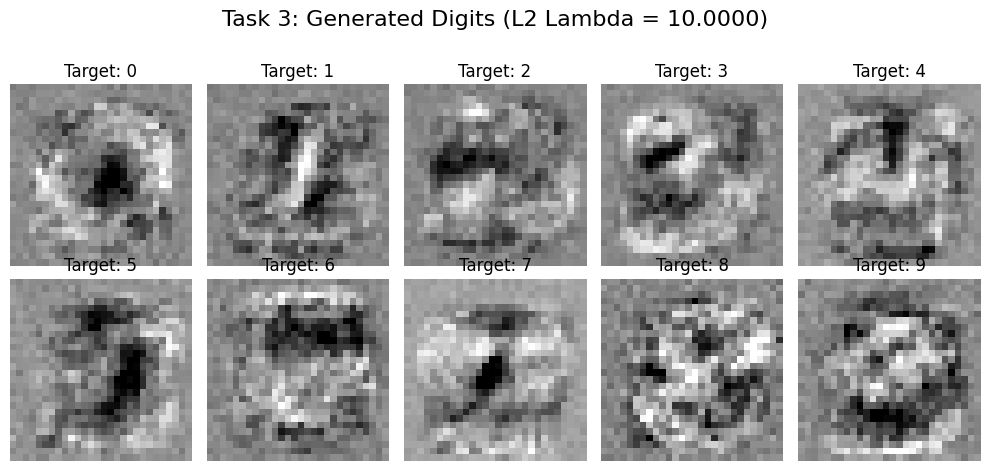

lambda_l2 = 46.4159
(lambda=46.4159) Step [200/500], Total Loss: 0.0451, Class Loss: 0.0107, L2 Pen: 0.0344, Acc: 1.00
(lambda=46.4159) Step [400/500], Total Loss: 0.0451, Class Loss: 0.0107, L2 Pen: 0.0344, Acc: 1.00
(lambda=46.4159) Final Results:
Image 0: Target=0, Predicted=0, Confidence=0.9912 [Correct]
Image 1: Target=1, Predicted=1, Confidence=0.9922 [Correct]
Image 2: Target=2, Predicted=2, Confidence=0.9922 [Correct]
Image 3: Target=3, Predicted=3, Confidence=0.9916 [Correct]
Image 4: Target=4, Predicted=4, Confidence=0.9923 [Correct]
Image 5: Target=5, Predicted=5, Confidence=0.9877 [Correct]
Image 6: Target=6, Predicted=6, Confidence=0.9882 [Correct]
Image 7: Target=7, Predicted=7, Confidence=0.9917 [Correct]
Image 8: Target=8, Predicted=8, Confidence=0.9828 [Correct]
Image 9: Target=9, Predicted=9, Confidence=0.9838 [Correct]
Total accuracy for lambda=46.4159: 10/10


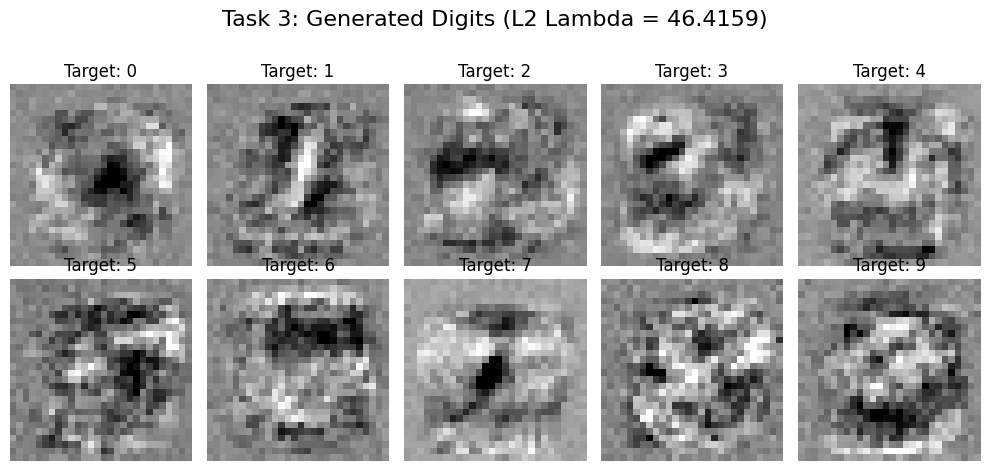

lambda_l2 = 215.4435
(lambda=215.4435) Step [200/500], Total Loss: 0.1416, Class Loss: 0.0392, L2 Pen: 0.1024, Acc: 1.00
(lambda=215.4435) Step [400/500], Total Loss: 0.1419, Class Loss: 0.0389, L2 Pen: 0.1030, Acc: 1.00
(lambda=215.4435) Final Results:
Image 0: Target=0, Predicted=0, Confidence=0.9682 [Correct]
Image 1: Target=1, Predicted=1, Confidence=0.9708 [Correct]
Image 2: Target=2, Predicted=2, Confidence=0.9709 [Correct]
Image 3: Target=3, Predicted=3, Confidence=0.9685 [Correct]
Image 4: Target=4, Predicted=4, Confidence=0.9712 [Correct]
Image 5: Target=5, Predicted=5, Confidence=0.9584 [Correct]
Image 6: Target=6, Predicted=6, Confidence=0.9574 [Correct]
Image 7: Target=7, Predicted=7, Confidence=0.9701 [Correct]
Image 8: Target=8, Predicted=8, Confidence=0.9415 [Correct]
Image 9: Target=9, Predicted=9, Confidence=0.9426 [Correct]
Total accuracy for lambda=215.4435: 10/10


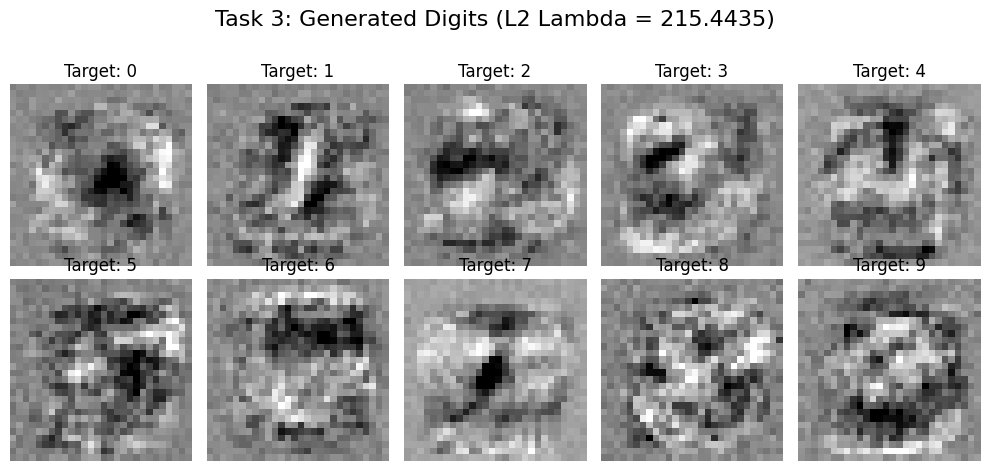

lambda_l2 = 1000.0000
(lambda=1000.0000) Step [200/500], Total Loss: 0.4120, Class Loss: 0.1399, L2 Pen: 0.2721, Acc: 1.00
(lambda=1000.0000) Step [400/500], Total Loss: 0.4142, Class Loss: 0.1408, L2 Pen: 0.2734, Acc: 1.00
(lambda=1000.0000) Final Results:
Image 0: Target=0, Predicted=0, Confidence=0.8834 [Correct]
Image 1: Target=1, Predicted=1, Confidence=0.8964 [Correct]
Image 2: Target=2, Predicted=2, Confidence=0.8970 [Correct]
Image 3: Target=3, Predicted=3, Confidence=0.8918 [Correct]
Image 4: Target=4, Predicted=4, Confidence=0.9059 [Correct]
Image 5: Target=5, Predicted=5, Confidence=0.8601 [Correct]
Image 6: Target=6, Predicted=6, Confidence=0.8507 [Correct]
Image 7: Target=7, Predicted=7, Confidence=0.8965 [Correct]
Image 8: Target=8, Predicted=8, Confidence=0.8138 [Correct]
Image 9: Target=9, Predicted=9, Confidence=0.8090 [Correct]
Total accuracy for lambda=1000.0000: 10/10


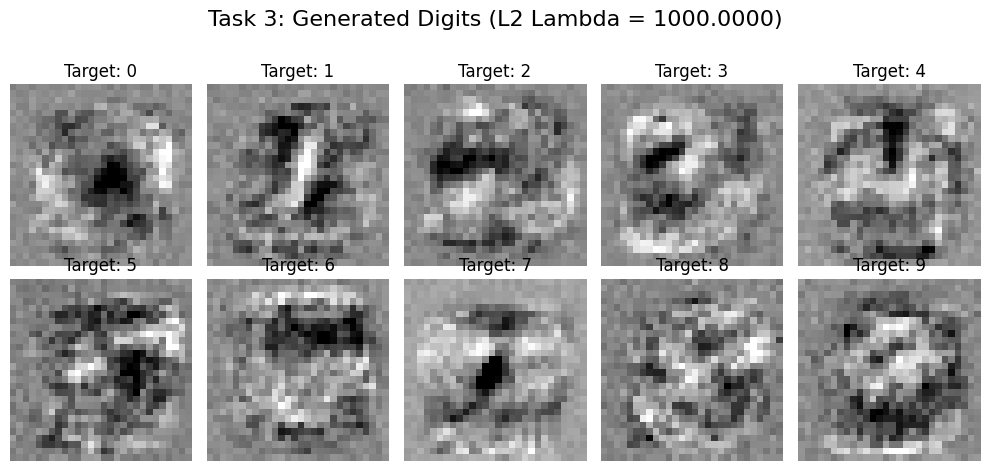

In [ ]:
# L2 penalty coefficients to test
lambda_l2_values = np.logspace(-3, 3, 10) # Exponential progression

# Optimization parameters (might need adjustments depending on lambda)
learning_rate_task3 = 0.05
num_steps_task3 = 500

# Store results for comparison
results_task3 = {}

# Loop through different L2 penalties
for lambda_l2 in lambda_l2_values:
    print(f"lambda_l2 = {lambda_l2:.4f}")

    # Initialize input batch with Gaussian noise (start fresh for each lambda)
    dreamed_input_batch_task3 = torch.randn(10, 1, 28, 28, device=device, requires_grad=True)

    # Target labels (same as Task 1)
    target_labels_task3 = torch.arange(10, device=device)

    # Optimizer
    optimizer_task3 = torch.optim.Adam([dreamed_input_batch_task3], lr=learning_rate_task3)

    # Loss function (CrossEntropy only, L2 added separately)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Optimization loop
    for step in range(num_steps_task3):
        optimizer_task3.zero_grad()

        # Forward pass
        outputs = model(dreamed_input_batch_task3)

        # Calculate classification loss
        classification_loss = loss_fn(outputs, target_labels_task3)

        # Calculate L2 penalty on the input image pixels
        # L2 = mean of squared pixel values
        l2_penalty = lambda_l2 * dreamed_input_batch_task3.pow(2).mean()

        # Total loss
        total_loss = classification_loss + l2_penalty

        # Backward pass
        total_loss.backward()

        # Update step
        optimizer_task3.step()

        # Optional clamping (less critical with L2, but can still be useful)
        # dreamed_input_batch_task3.data.clamp_(mean - 3*std, mean + 3*std)

        if (step + 1) % 200 == 0: # Print less frequently
             with torch.no_grad():
                 pred = model(dreamed_input_batch_task3).argmax(dim=1)
                 accuracy = (pred == target_labels_task3).float().mean()
             print(f'(lambda={lambda_l2:.4f}) Step [{step+1}/{num_steps_task3}], Total Loss: {total_loss.item():.4f}, Class Loss: {classification_loss.item():.4f}, L2 Pen: {l2_penalty.item():.4f}, Acc: {accuracy.item():.2f}')

    # Store final results
    with torch.no_grad():
        final_outputs = model(dreamed_input_batch_task3)
        final_probs = torch.nn.functional.softmax(final_outputs, dim=1)
        final_preds = final_probs.argmax(dim=1)
        confidences = final_probs.max(dim=1)[0]

    print(f"(lambda={lambda_l2:.4f}) Final Results:")
    correct_count = 0
    for i in range(10):
        is_correct = final_preds[i].item() == target_labels_task3[i].item()
        if is_correct: correct_count += 1
        print(f"Image {i}: Target={target_labels_task3[i].item()}, Predicted={final_preds[i].item()}, Confidence={confidences[i].item():.4f} {'[Correct]' if is_correct else '[Incorrect]'}")
    print(f"Total accuracy for lambda={lambda_l2:.4f}: {correct_count}/10")


    # Visualize and store
    plot_images(dreamed_input_batch_task3, target_labels_task3.cpu().numpy(), title=f"Task 3: Generated Digits (L2 Lambda = {lambda_l2:.4f})")
    results_task3[lambda_l2] = {
        'images': dreamed_input_batch_task3.detach().clone(),
        'preds': final_preds.cpu().numpy(),
        'targets': target_labels_task3.cpu().numpy(),
        'accuracy': correct_count / 10.0
    }

For small to moderate values of `lambda_l2` (e.g., $0.001$ to $0.1$, maybe up to $1.0$), the network usually still recognizes the generated images correctly or with high accuracy. The optimization objective is a balance between minimizing classification loss and minimizing the $L_2$ norm of the input.

As `lambda_l2` becomes larger (e.g., $10.0$), the $L_2$ penalty dominates the total loss. The optimizer prioritizes making the image pixels close to zero (minimizing `image.pow(2).mean()`) over satisfying the classification goal. This can lead to images that are very faint, blurry, or just gray noise, which the network may no longer classify correctly. Accuracy will likely drop significantly at high lambda values.

**Impact**:
The $L_2$ penalty acts as a regularizer on the input space. It discourages solutions (images) with large pixel values (far from zero, both positive and negative).

**Effect on Quality**:
*Reduced Noise**: The most noticeable effect is a significant reduction in high-frequency noise compared to Task 1. The penalty forces the optimizer to find solutions that are "lower energy."

*Smoother Images*: This often results in visually smoother and less "aggressive" or "sparkly" images. The sharp, high-contrast noise patterns that might efficiently trigger the classifier (but look unnatural) are penalized.

*More "Natural" Appearance*: By suppressing extreme pixel values and noise, the resulting images may look slightly more like plausible, albeit simple or stylized, digits, especially at moderate lambda values (e.g., $0.01$ - $0.1$). They might focus more on the core shape.

*Lower Contrast*: As `lambda_l2` increases, the overall magnitude of pixel values is pushed down. Images become fainter and lower contrast. Very high lambda values result in images that are mostly gray or black, as the optimizer sacrifices classification accuracy to minimize the $L_2$ norm.

*Explanation*: The $L_2$ penalty `lambda_l2 * dreamed_input_batch.pow(2).mean()` adds a cost proportional to the average squared pixel value. Gradient descent will thus not only push pixels in directions that improve classification but also pull pixel values towards zero. This discourages sparse, high-magnitude activations (like sharp noise) and favors smoother, lower-magnitude solutions. We can observe some kind of trade-off: too little `lambda_l2` doesn't suppress noise effectively; too much lambda suppresses the signal (the digit features) itself. An optimal `lambda_l2`, which is often found empirically, yields a good balance, producing relatively clean images that are still correctly classified.